In [2]:
%load_ext autoreload
%autoreload 2
import featureman.gen_data as man
import torch
import torch.nn as nn
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:

model_dict = torch.load("modular_arithmetic_model.pth", map_location=device)
model = man.OneLayerTransformer(p=113, d_model=128, nheads=4).to(device)
model.load_state_dict(model_dict)

<All keys matched successfully>

In [6]:
torch.manual_seed(1337)
# generate combination of all inputs a and b range (113)
a = np.arange(113)
b = np.arange(113)
# generate inputs for the model
inputs = np.array([[a_i, 113, b_i, 114] for a_i in a for b_i in b])
inputs = torch.tensor(inputs).to(device)  # Add batch dimension
print(inputs.shape)
logits, activations = model(inputs, return_activations=True)

torch.Size([12769, 4])


In [7]:
activations_data = activations[:, -1, :] #shape [n_samples, d_model]
activations_data = activations_data.detach().cpu()
#shuffle and split
indices = torch.randperm(activations_data.shape[0])
n_samples = activations_data.shape[0]
split_idx = int(0.8 * n_samples)
train_indices = indices[:split_idx]
test_indices = indices[split_idx:]

activations_train = activations_data[train_indices]
activations_test = activations_data[test_indices]
# to created batched version just repeat 5 times stacked

batched_acts = activations_train.unsqueeze(0).repeat(5, 1, 1).to(device)

activations_train

tensor([[0.6279, 0.0000, 0.0483,  ..., 0.9191, 0.2596, 0.4742],
        [0.0000, 1.3565, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.3152, 0.0000, 0.1177,  ..., 0.0000, 0.0287, 0.6013],
        ...,
        [0.0000, 0.0000, 0.1213,  ..., 0.6463, 0.0972, 0.6923],
        [0.5849, 0.0000, 0.0743,  ..., 0.0000, 0.0000, 0.6800],
        [0.3997, 0.5107, 0.0062,  ..., 0.0000, 0.0505, 0.0000]])

In [209]:

sae = man.BatchedSAE_Updated(input_dim=512, n_models=5, width_ratio=4).to(device)
l1_lams = torch.tensor([1e1, 2e1, 3e1, 4e1, 5e1]).to(device)
# train the model
result = sae.fit(train_data = batched_acts, test_data=torch.tensor([]), l1_lam=l1_lams)

<string>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).


Model 0, Epoch 0, Loss: 0.8656, MSE: 0.8656, L1: 0.0000, L0: 1717.5616
Model 1, Epoch 0, Loss: 0.9174, MSE: 0.9174, L1: 0.0000, L0: 1730.8091
Model 2, Epoch 0, Loss: 0.8293, MSE: 0.8293, L1: 0.0000, L0: 1716.1100
Model 3, Epoch 0, Loss: 0.8203, MSE: 0.8203, L1: 0.0000, L0: 1715.1174
Model 4, Epoch 0, Loss: 0.8212, MSE: 0.8212, L1: 0.0000, L0: 1715.1799
Model 0, Epoch 10, Loss: 0.0263, MSE: 0.0263, L1: 0.1978, L0: 526.2392
Model 1, Epoch 10, Loss: 0.0445, MSE: 0.0445, L1: 0.3621, L0: 527.5432
Model 2, Epoch 10, Loss: 0.0737, MSE: 0.0737, L1: 0.5037, L0: 181.1730
Model 3, Epoch 10, Loss: 0.1104, MSE: 0.1104, L1: 0.6326, L0: 134.2761
Model 4, Epoch 10, Loss: 0.1495, MSE: 0.1495, L1: 0.7396, L0: 112.7249
Model 0, Epoch 20, Loss: 0.0361, MSE: 0.0361, L1: 0.3470, L0: 338.1864
Model 1, Epoch 20, Loss: 0.0921, MSE: 0.0921, L1: 0.6212, L0: 380.1906
Model 2, Epoch 20, Loss: 0.1668, MSE: 0.1668, L1: 0.8239, L0: 73.7232
Model 3, Epoch 20, Loss: 0.2591, MSE: 0.2591, L1: 0.9726, L0: 33.6744
Model 4,

In [210]:
for results in result:
    print(f"Results for L1 lambda {results['L1 lambda']}:")
    print(f"MSE: {results['mse']:.4f}, L0: {results['L0']:.4f}")

Results for L1 lambda 10.0:
MSE: 0.0614, L0: 227.7622
Results for L1 lambda 20.0:
MSE: 0.1061, L0: 92.3322
Results for L1 lambda 30.0:
MSE: 0.1819, L0: 57.9388
Results for L1 lambda 40.0:
MSE: 0.2874, L0: 12.7754
Results for L1 lambda 50.0:
MSE: 0.4019, L0: 7.5076


In [211]:
batched_acts.shape

torch.Size([5, 10215, 512])

In [8]:
_, _, feats, recon = sae(batched_acts[:, :60, :])  # Test the model with the first sample

In [213]:
feats.shape

torch.Size([5, 60, 2048])

In [214]:
feats[0,0].shape
def determine_l1(features):
    # Calculate the L0 norm (number of non-zero elements)
    l0 = torch.count_nonzero(features, dim=1).float().mean().item()
    return l0

In [215]:
determine_l1(feats[4])

7.216667175292969

In [216]:
feats.shape

torch.Size([5, 60, 2048])

In [217]:
print(feats[0].shape)

inputs[0]

torch.Size([60, 2048])


tensor([  0, 113,   0, 114], device='cuda:0')

In [223]:
torch.save(sae.state_dict(), "sae_model.pth")

In [3]:
sae_dict = torch.load("sae_model.pth", map_location=device)
sae = man.BatchedSAE_Updated(input_dim=512, n_models=5, width_ratio=4).to(device)
sae.load_state_dict(sae_dict)

<All keys matched successfully>

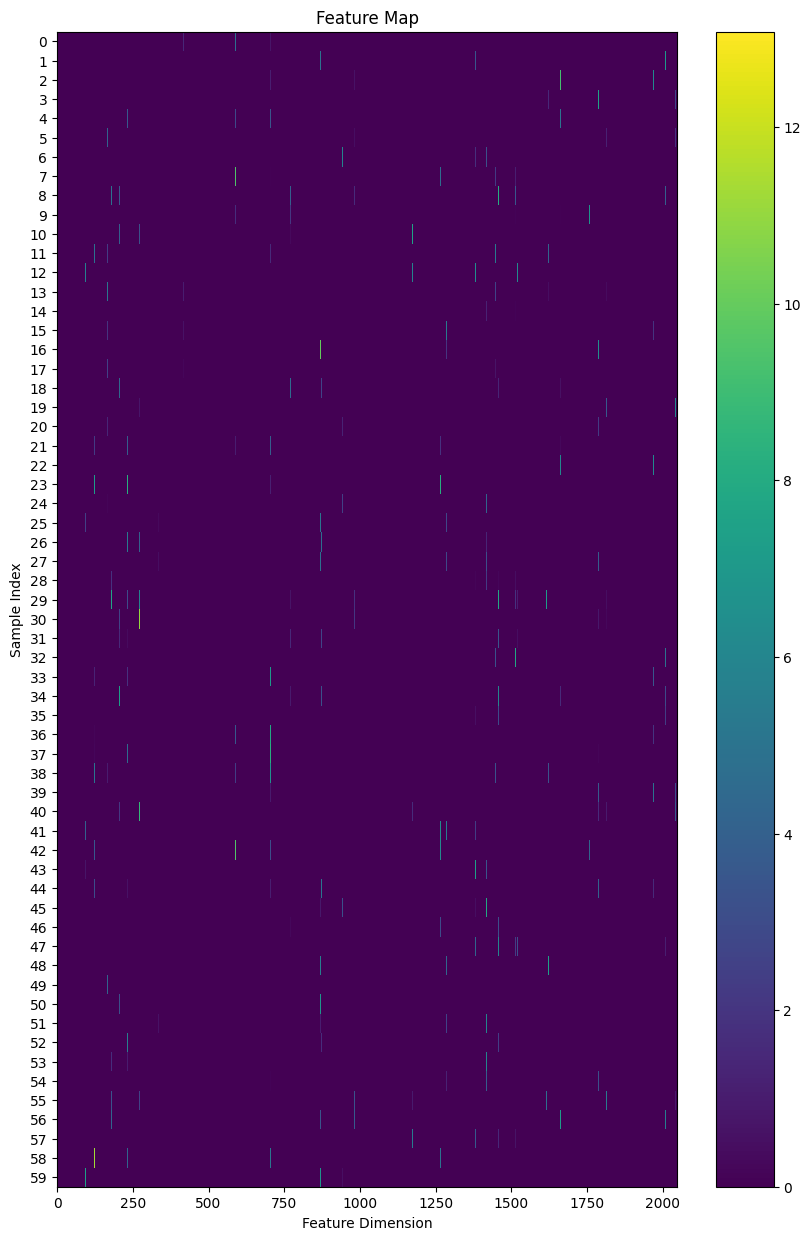

In [9]:
from matplotlib import pyplot as plt

feat = feats[3].detach().cpu().numpy()  # Convert to numpy for further processing if needed
plt.figure(figsize=(10, 15))
plt.imshow(feat, cmap='viridis', aspect='auto', interpolation='None')
#make y axis intergers
plt.yticks(ticks=np.arange(feat.shape[0]), labels=np.arange(feat.shape[0]))
plt.colorbar()
plt.title("Feature Map")
plt.xlabel("Feature Dimension")
plt.ylabel("Sample Index")
plt.show()

In [11]:
_, _, feats, recon = sae(batched_acts)  # Test the model with the first sample

In [12]:
import torch.nn.functional as F

cos_sim = F.cosine_similarity(recon, batched_acts, dim=2)

mean_cos_sim = cos_sim.mean(dim=1)

mean_cos_sim

tensor([0.9871, 0.9811, 0.9684, 0.9586, 0.9433], device='cuda:0',
       grad_fn=<MeanBackward1>)

In [13]:
batched_acts = batched_acts.cpu().numpy()
recon = recon.detach().cpu().numpy()

In [14]:
dot = np.einsum('msd,msd->ms', recon, batched_acts)
act_norm_sq = np.einsum('msd,msd->ms', batched_acts, batched_acts)
alpha = (dot / act_norm_sq + 1e-8)[:,:,None]
proj = alpha * batched_acts

mean_alpha = alpha.squeeze(-1).mean(axis=1)

mean_alpha

array([0.93493944, 0.8987832 , 0.85453653, 0.8067285 , 0.7546353 ],
      dtype=float32)